In [21]:
import numpy as np
# from qubovert.problems import JobSequencing, VertexCover
from qubovert.utils import solve_qubo_bruteforce as qubo_solver

In [ ]:
edges = {("a", "b"), ("b", "c")}

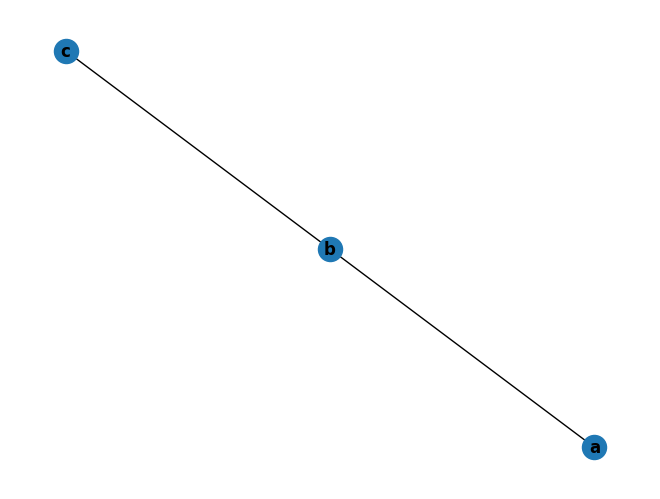

In [22]:
# draw the graph
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

In [14]:
def matprint(mat, fmt="g"):
    """https://gist.github.com/braingineer/d801735dac07ff3ac4d746e1f218ab75"""
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

In [25]:
A = 1
B = 1
c = 3

In [8]:
Q = np.array([
    [-A, A, B, 0, 0, 0],
    [A, -A, 0, B, 0, 0],
    [B, 0, -A, A, B, 0],
    [0, B, A, -A, 0, B],
    [0, 0, B, 0, -A, A],
    [0, 0, 0, B, A, -A],
])

In [15]:
matprint(Q)

-1   1   1   0   0   0  
 1  -1   0   1   0   0  
 1   0  -1   1   1   0  
 0   1   1  -1   0   1  
 0   0   1   0  -1   1  
 0   0   0   1   1  -1  


# Pulser

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice
from pulser.waveforms import InterpolatedWaveform
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

In [26]:
bitstrings = [np.binary_repr(i, len(Q)) for i in range(2 ** len(Q))]
costs = []
# this takes exponential time with the dimension of the QUBO
for b in bitstrings:
    z = np.array(list(b), dtype=int)
    cost = z.T @ Q @ z + c * A
    costs.append(cost)
zipped = zip(bitstrings, costs)
sort_zipped = sorted(zipped, key=lambda x: x[1])
sols = [s[0] for s in sort_zipped[:3]]
sort_zipped[:3]

[('011001', 0), ('100110', 0), ('000110', 1)]

$ z = (x_{a0}, x_{a1}, x_{b0}, x_{b1}, x_{c0}, x_{c1}) $
with $x_{vc}$ a binary variable for vertex $v$ and color $i$.

011001:   
- a: color 1   
- b: color 0   
- c: color 1

correct

In [27]:
def evaluate_mapping(new_coords, Q):
    """Cost function to minimize. Ideally, the pairwise distances are conserved."""
    new_coords = np.reshape(new_coords, (len(Q), 2))
    # computing the matrix of the distances between all coordinate pairs
    new_Q = squareform(
        DigitalAnalogDevice.interaction_coeff / pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

In [334]:
q_multiplier = 5
costs = []
np.random.seed(18) # 4
x0 = np.random.random(len(Q) * 2)
res = minimize(
    evaluate_mapping,
    x0,
    args=(q_multiplier*Q,),
    method="Nelder-Mead",
    # method="CG",
    # method="COBYQA",
    # method = "L-BFGS-B",
    # method = "Powell",
    # method = "trust-constr",
    tol=1e-6,
    options={"maxiter": 20000000, "maxfev": None},
    bounds = [(-40, 40) for _ in range(len(Q) * 2)]
)
coords = np.reshape(res.x, (len(Q), 2))

In [ ]:
Q_new = squareform(
    DigitalAnalogDevice.interaction_coeff / pdist(coords) ** 6
)
# matprint(Q_new)
# matprint(Q)
matprint(q_multiplier*Q - Q_new)

        -5   0.0131791  0.0651005  -0.0836366   -1.26938  -0.0471658  
 0.0131791          -5  -0.132172      4.9857  -0.470473  -0.0216875  
 0.0651005   -0.132172         -5    0.120836  0.0334128   -0.432678  
-0.0836366      4.9857   0.120836          -5  -0.917725   0.0591504  
  -1.26938   -0.470473  0.0334128   -0.917725         -5   0.0897345  
-0.0471658  -0.0216875  -0.432678   0.0591504  0.0897345          -5  


In [403]:
q_multiplier * Q - Q_new

array([[-5.        ,  0.01317915,  0.06510047, -0.0836366 , -1.2693805 ,
        -0.0471658 ],
       [ 0.01317915, -5.        , -0.1321721 ,  4.98570083, -0.47047338,
        -0.02168751],
       [ 0.06510047, -0.1321721 , -5.        ,  0.12083565,  0.03341276,
        -0.4326783 ],
       [-0.0836366 ,  4.98570083,  0.12083565, -5.        , -0.91772515,
         0.05915038],
       [-1.2693805 , -0.47047338,  0.03341276, -0.91772515, -5.        ,
         0.08973447],
       [-0.0471658 , -0.02168751, -0.4326783 ,  0.05915038,  0.08973447,
        -5.        ]])

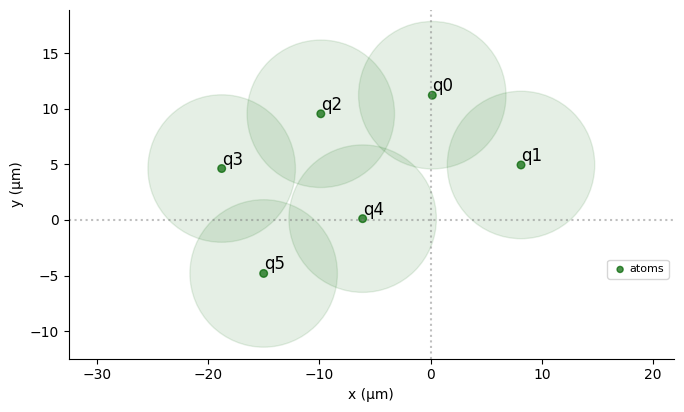

In [342]:
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}
reg = Register(qubits)
reg.draw(
    blockade_radius=DigitalAnalogDevice.rydberg_blockade_radius(1.0),
    draw_graph=False,
    draw_half_radius=True,
)

In [398]:
# We choose a median value between the min and the max
# Omega = np.median(Q[Q > 0].flatten())
# Omega = np.median(Q[Q > 1e-3].flatten())
Omega = 10.
delta_0 = -5.0  # just has to be negative
delta_f = -delta_0  # just has to be positive
T = 10_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system

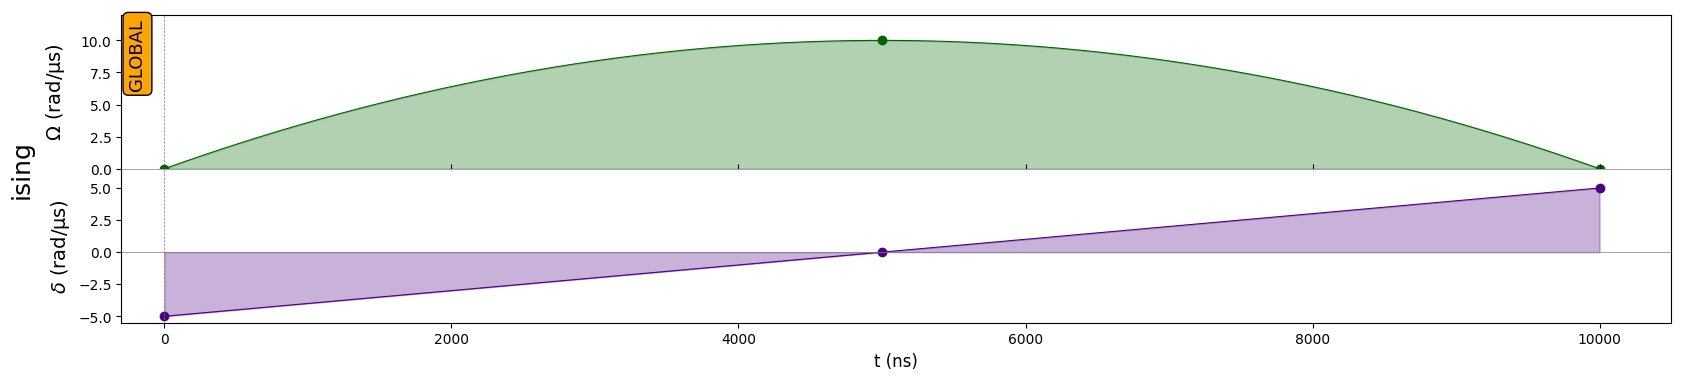

In [399]:
adiabatic_pulse = Pulse(
    InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
    InterpolatedWaveform(T, [delta_0, 0, delta_f]),
    0,
)
seq = Sequence(reg, DigitalAnalogDevice)
seq.declare_channel("ising", "rydberg_global")
seq.add(adiabatic_pulse, "ising")
seq.draw()

In [400]:
simul = QutipEmulator.from_sequence(seq)
results = simul.run()
final = results.get_final_state()
count_dict = results.sample_final_state()

In [401]:
def plot_distribution(C, sols=[]):
    C = dict(sorted(C.items(), key=lambda item: item[1], reverse=True))
    color_dict = {key: "r" if key in sols else "g" for key in C}
    plt.figure(figsize=(12, 6))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.5, color=color_dict.values())
    plt.xticks(rotation="vertical")
    plt.show()

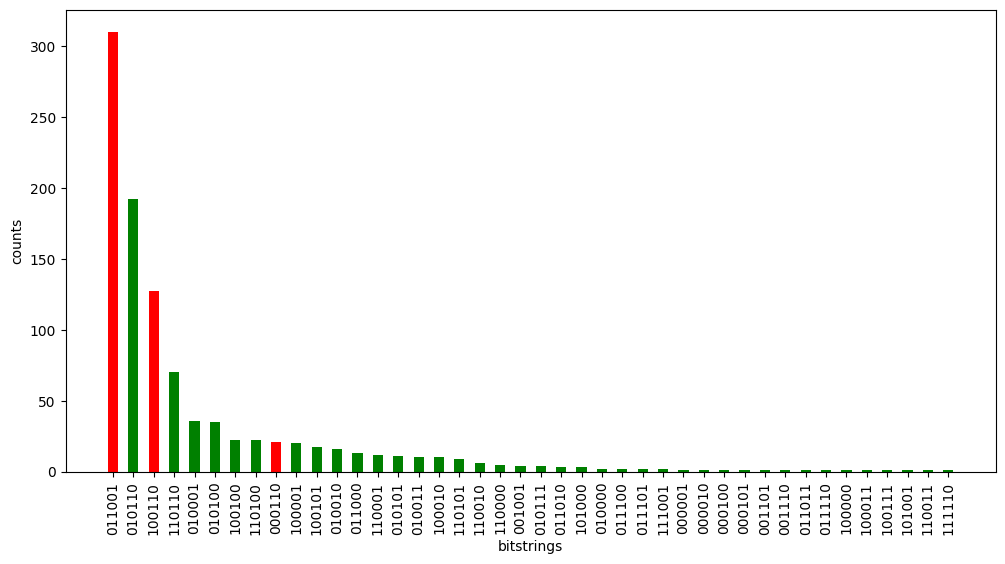

In [402]:
plot_distribution(count_dict, sols)

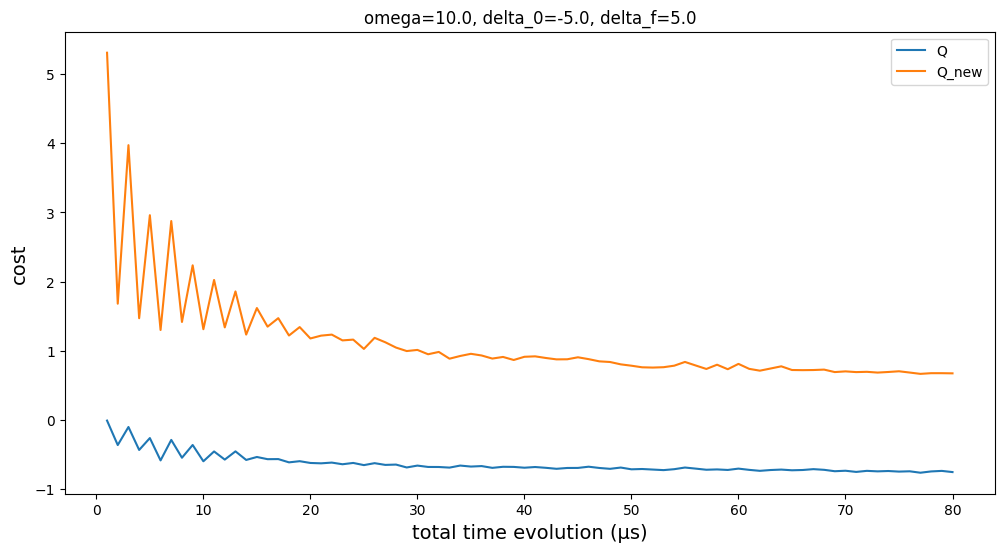

In [392]:
def get_cost_colouring(bitstring, Q):
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost

def get_cost(counter, Q):
    cost = sum(counter[key] * get_cost_colouring(key, Q) for key in counter)
    return cost / sum(counter.values())  # Divide by total samples

cost_Q = []
cost_newQ = []
nn = 1 # takes very long, can also set to 1
t_end = 80
correct_counts = []
for T in 1000 * np.linspace(1, t_end, t_end*nn):
    seq = Sequence(reg, DigitalAnalogDevice)
    seq.declare_channel("ising", "rydberg_global")
    adiabatic_pulse = Pulse(
        InterpolatedWaveform(T, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(T, [delta_0, 0, delta_f]),
        0,
    )
    seq.add(adiabatic_pulse, "ising")
    simul = QutipEmulator.from_sequence(seq)
    results = simul.run()
    final = results.get_final_state()
    count_dict = results.sample_final_state()
    cost_newQ.append(get_cost(count_dict, Q_new) / 3)
    cost_Q.append(get_cost(count_dict, Q) / 3)
    correct_counts.append([count_dict.get(s, 0) / sum(count_dict.values()) for s in sols])

correct_counts = np.array(correct_counts)

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cost_Q)+1), np.array(cost_Q), label="Q")
plt.plot(range(1, len(cost_newQ)+1), np.array(cost_newQ), label="Q_new")
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("cost", fontsize=14)
plt.title(f"omega={Omega}, delta_0={delta_0}, delta_f={delta_f}")
plt.legend()
plt.show()

Text(0.5, 1.0, 'omega=10.0, delta_0=-5.0, delta_f=5.0')

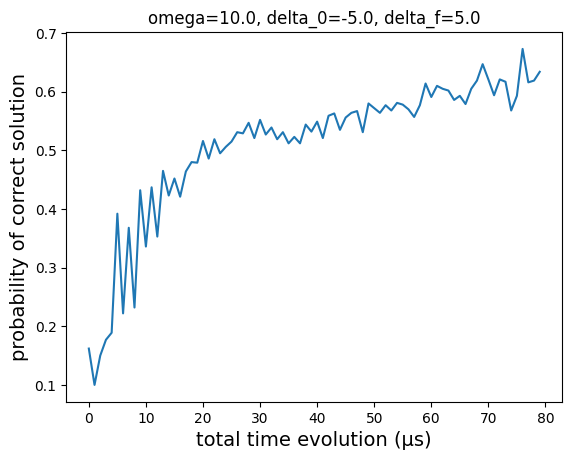

In [391]:
plt.plot(correct_counts[:, 0] + correct_counts[:, 1])
plt.xlabel("total time evolution (µs)", fontsize=14)
plt.ylabel("probability of correct solution", fontsize=14)
plt.title(f"omega={Omega}, delta_0={delta_0}, delta_f={delta_f}")